# Réalisez une application de recommandation de contenu

## Librairies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import pickle
from surprise import Reader, Dataset
from surprise import dump, accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from collections import defaultdict
from operator import itemgetter
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from math import floor
from heapq import nlargest

C:\Users\Utilisateur\anaconda3\envs\OC_P09\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Settings

In [2]:
plt.style.use("dark_background")

## Données

### Téléchargement

In [36]:
remote_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip"
data_path = "./data/"
local_file = data_path + "news-portal-user-interactions-by-globocom.zip"

In [3]:
data = requests.get(remote_url)
with open(local_file, 'wb')as file:
    file.write(data.content)

In [12]:
os.listdir(data_path)

['news-portal-user-interactions-by-globocom.zip']

### Décompression

In [13]:
with zipfile.ZipFile(local_file, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [14]:
os.listdir(data_path)

['articles_embeddings.pickle',
 'articles_metadata.csv',
 'clicks.zip',
 'clicks_sample.csv',
 'news-portal-user-interactions-by-globocom.zip']

In [18]:
with zipfile.ZipFile(data_path+"clicks.zip", 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [4]:
clicks_path = data_path + "clicks/"

In [19]:
os.listdir(clicks_path)

['clicks_hour_000.csv',
 'clicks_hour_001.csv',
 'clicks_hour_002.csv',
 'clicks_hour_003.csv',
 'clicks_hour_004.csv',
 'clicks_hour_005.csv',
 'clicks_hour_006.csv',
 'clicks_hour_007.csv',
 'clicks_hour_008.csv',
 'clicks_hour_009.csv',
 'clicks_hour_010.csv',
 'clicks_hour_011.csv',
 'clicks_hour_012.csv',
 'clicks_hour_013.csv',
 'clicks_hour_014.csv',
 'clicks_hour_015.csv',
 'clicks_hour_016.csv',
 'clicks_hour_017.csv',
 'clicks_hour_018.csv',
 'clicks_hour_019.csv',
 'clicks_hour_020.csv',
 'clicks_hour_021.csv',
 'clicks_hour_022.csv',
 'clicks_hour_023.csv',
 'clicks_hour_024.csv',
 'clicks_hour_025.csv',
 'clicks_hour_026.csv',
 'clicks_hour_027.csv',
 'clicks_hour_028.csv',
 'clicks_hour_029.csv',
 'clicks_hour_030.csv',
 'clicks_hour_031.csv',
 'clicks_hour_032.csv',
 'clicks_hour_033.csv',
 'clicks_hour_034.csv',
 'clicks_hour_035.csv',
 'clicks_hour_036.csv',
 'clicks_hour_037.csv',
 'clicks_hour_038.csv',
 'clicks_hour_039.csv',
 'clicks_hour_040.csv',
 'clicks_hour_04

## Fonctions usuelles

In [5]:
def get_limits(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - (1.5*IQR)
    lim_sup = Q3 + (1.5*IQR)
    return lim_inf, lim_sup

def get_outliers(df, column):
    lim_inf, lim_sup = get_limits(df, column)
    return df[(df[column]<lim_inf) | (df[column]>lim_sup)]

## Analyse des données

In [6]:
df = {}

### articles_metadata.csv

In [7]:
df["articles_metadata"] = pd.read_csv(
    data_path + "articles_metadata.csv"
)
df["articles_metadata"].head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [28]:
df["articles_metadata"].shape

(364047, 5)

In [29]:
df["articles_metadata"].describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [61]:
df["articles_metadata"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


#### Description des colonnes

- **article_id** : identifiant de l'article
- **category_id** : identifiant de la catégorie
- **created_at_ts** : date de création
- **publisher_id** : ne contient que la valeur 0
- **words_count** : nombre de mots de l'article

In [63]:
nb_articles = len(df["articles_metadata"]["article_id"].unique())
nb_categories = len(df["articles_metadata"]["category_id"].unique())
nb_publisher_id = len(df["articles_metadata"]["publisher_id"].unique())

print("Dans le jeu de données articles_metadata.csv, il y a :")
print("- {} articles".format(nb_articles))
print("- {} catégories".format(nb_categories))
print("- {} éditeurs".format(nb_publisher_id))

Dans le jeu de données articles_metadata.csv, il y a :
- 364047 articles
- 461 catégories
- 1 éditeurs


#### Valeurs manquantes

In [26]:
df["articles_metadata"].isna().sum()

article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64

Il n'y a pas de valeur manquante, excepté dans la colonne **publisher_id** où toutes les valeurs sont 0

#### Colonne words_count

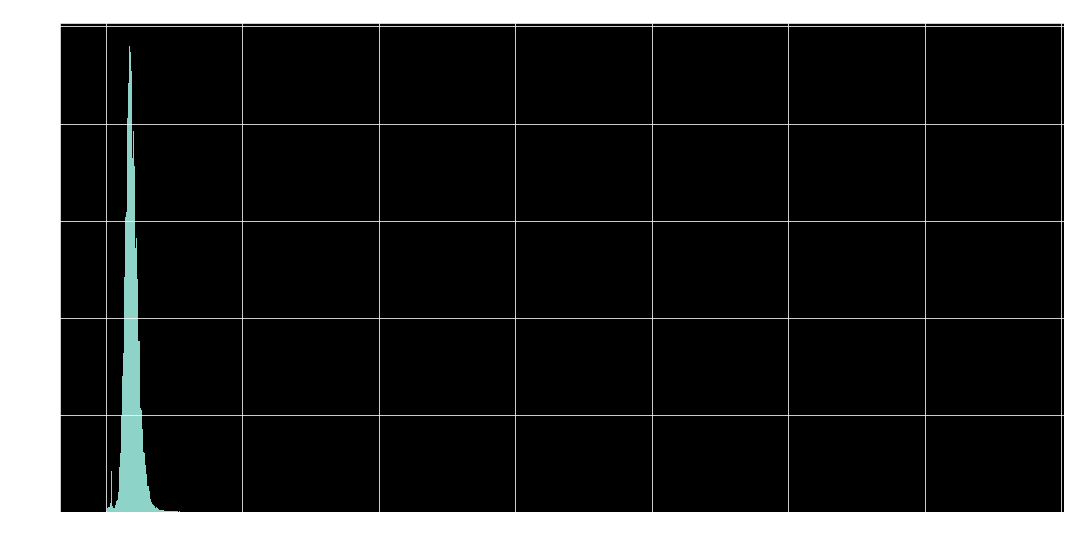

In [27]:
df["articles_metadata"]["words_count"].hist(
    figsize=(18,9),
    bins=1000,
)

plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.title("Nombre de mots par article")
plt.show()

C:\Users\Utilisateur\anaconda3\envs\OC_P09\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


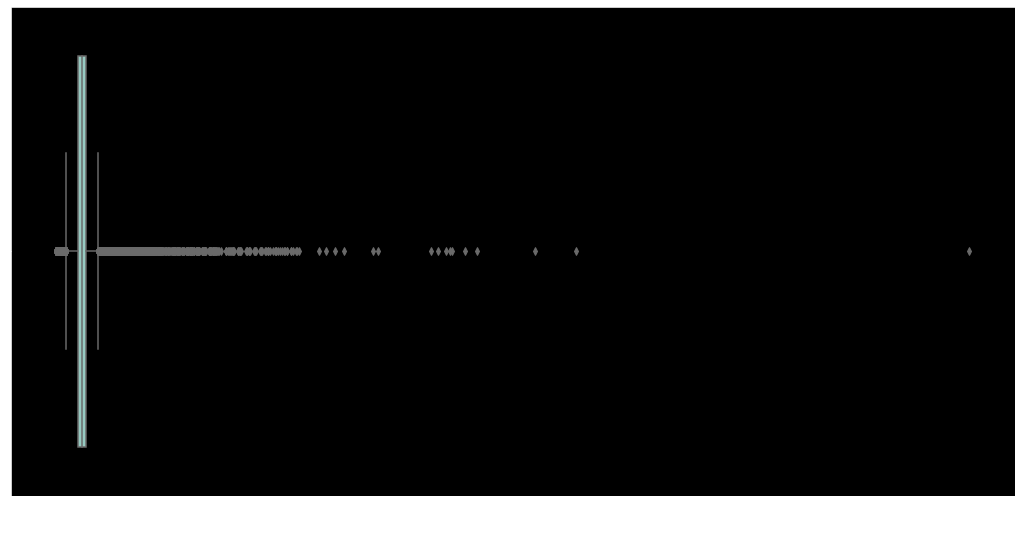

In [30]:
plt.figure(figsize=(18,9))
sns.boxplot(
    df['articles_metadata']["words_count"]
)
plt.show()

In [7]:
lim_inf, lim_sup = get_limits(df['articles_metadata'], "words_count")
print("La majorité des articles comprennent entre {} et {} mots".format(lim_inf, lim_sup))

La majorité des articles comprennent entre 70.5 et 306.5 mots


#### Colonne category_id

In [8]:
nb_cat = len(df['articles_metadata']["category_id"].unique())
print("Il y a {} catégories d'articles différentes".format(nb_cat))

Il y a 461 catégories d'articles différentes


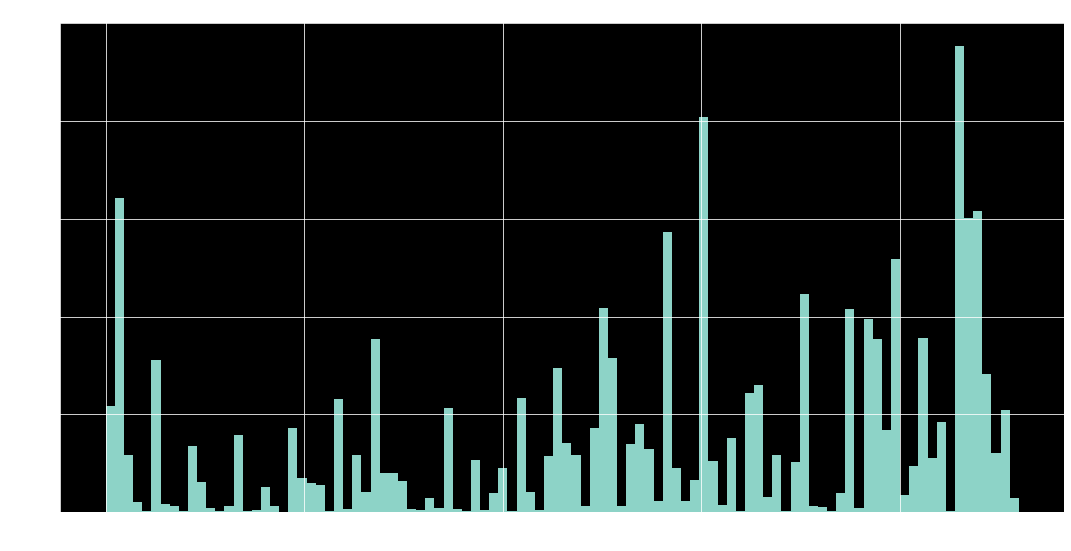

In [33]:
df['articles_metadata']['category_id'].hist(figsize=(18,9), bins=100)
plt.xlabel("Identifiant de catégorie")
plt.ylabel("Nombre")
plt.title("Distribution des catégories")
plt.show()

### clicks_sample.csv

Ce fichier est un échantillon des fichiers csv contenus dans clicks.zip

In [8]:
df["clicks_sample"] = pd.read_csv(
    data_path + "clicks_sample.csv"
)
df["clicks_sample"].head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


### clicks.csv

In [9]:
df["clicks"] = pd.DataFrame()
clicks_path
for f in os.listdir(clicks_path):
    tmp_df = pd.read_csv(
        clicks_path + f, 
        index_col=None,
        header=0
    )
    df["clicks"] = pd.concat(
        [df["clicks"], tmp_df], 
        axis=0,
        ignore_index=True
    )

In [252]:
df["clicks"].head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [33]:
df["clicks"].describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7
top,5890,1507563657895091,1507563657000,2,160974,1506961009961,4,1,17,1,25,2
freq,1232,124,127,1260372,37213,3,2904478,1823162,1738138,2852406,804985,1602601


In [45]:
print("Le nombre total de sessions est de ", len(df["clicks"]["session_id"].unique()))
print("Le nombre total d'utilisateurs est de ", len(df["clicks"]["user_id"].unique()))
print("Le nombre total de clics est de ", len(df["clicks"]["click_timestamp"].unique()))

Le nombre total de sessions est de  1048594
Le nombre total d'utilisateurs est de  322897
Le nombre total de clics est de  2983198


In [46]:
df["clicks"].to_csv(data_path+"clicks.csv", sep='\t', index=False)

Nous allons regrouper chaque clic par utilisateur :

In [10]:
df["clicks_by_user"] = df["clicks"].groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)
df["clicks_by_user"]

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [11]:
file_path = data_path + "clicks_by_user.sav"

if not os.path.exists(file_path):
    
    df["clicks_by_user"]["categories"] = ""
    
    for index, row in df["clicks_by_user"].iterrows():
        ls_row = []
        for article in row["LIST_click_article_id"]:
            ls_row.append(
                df["articles_metadata"][df["articles_metadata"]["article_id"] == article]["category_id"].values[0]
            )
        df["clicks_by_user"].loc[index]["categories"] = ls_row
    pickle.dump(df["clicks_by_user"], open(file_path, "wb"))
else:
    df["clicks_by_user"] = pickle.load(open(file_path, "rb"))

In [12]:
pickle.dump(df, open("df.sav", "wb"))

In [12]:
df["clicks_by_user"]

,LIST_click_article_id,categories
user_id,,
0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"
...,...,...
322892,"[42567, 39894]","[67, 66]"
322893,"[50644, 36162]","[99, 43]"
322894,"[36162, 168401]","[43, 297]"


### Articles Embeddings

Il s'agit d'une matrice numpy contenant les plongements (embeddings) des articles entraînés sur les textes et les données des articles. Il s'agit de vecteurs de dimension 250

In [37]:
articles_embeddings = pd.read_pickle(data_path + "articles_embeddings.pickle")

In [66]:
print(articles_embeddings.shape)

(364047, 250)


In [68]:
articles_embeddings[0]

array([-0.16118301, -0.95723313, -0.13794445,  0.05085534,  0.83005524,
        0.90136534, -0.33514765, -0.55956066, -0.50060284,  0.16518293,
        0.4284342 ,  0.3550556 ,  0.87443674, -0.52888286,  0.6254872 ,
        0.2689198 , -0.8228351 , -0.703853  , -0.62584543, -0.15285493,
       -0.6662412 ,  0.04329487,  0.1786375 ,  0.04689008,  0.5945311 ,
       -0.18334764,  0.19510683, -0.46763963, -0.30480695,  0.35317516,
        0.27818817,  0.5386231 , -0.37120935,  0.48989806, -0.10383289,
        0.11917368,  0.13243659, -0.62108386, -0.45331132,  0.34662652,
       -0.06174106, -0.7305939 , -0.38411567, -0.94075835,  0.06134219,
        0.4825816 ,  0.28968322, -0.62269634, -0.05000444,  0.42151213,
       -0.24257636,  0.6687105 , -0.509004  , -0.46179956,  0.04390178,
        0.28848746,  0.4498246 , -0.28486234,  0.916729  ,  0.70312876,
        0.85167396, -0.6272441 ,  0.35773164,  0.3901894 ,  0.65293527,
        0.1036527 ,  0.79829276, -0.10254639, -0.2045143 ,  0.37

## Fusion de clicks et articles_metadata

In [14]:
df["user_article"] = df["clicks"].merge(
    df["articles_metadata"],
    left_on="click_article_id",
    right_on="article_id"
)

In [70]:
df["user_article"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2988180
Data columns (total 17 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
 12  article_id           int64 
 13  category_id          int64 
 14  created_at_ts        int64 
 15  publisher_id         int64 
 16  words_count          int64 
dtypes: int64(5), object(12)
memory usage: 410.4+ MB


In [78]:
df["user_article"].shape

(2988181, 17)

Explorons maintenant ce dataset :

#### Nombre d'utilisateurs

In [74]:
nb_users = df["user_article"]["user_id"].nunique()
print("Nombre d'utilisateurs : ", nb_users)

Nombre d'utilisateurs :  322897


#### Nombre d'articles

In [75]:
nb_articles = df["user_article"]["article_id"].nunique()
print("Nombre d'articles : ", nb_articles)

Nombre d'articles :  46033


#### Nombre de catégories

In [76]:
nb_cats = df["user_article"]["category_id"].nunique()
print("Nombre d'articles : ", nb_cats)

Nombre d'articles :  316


### Répartition du nombre de clics par session

In [80]:
np.max(df['user_article']['session_size'])

124

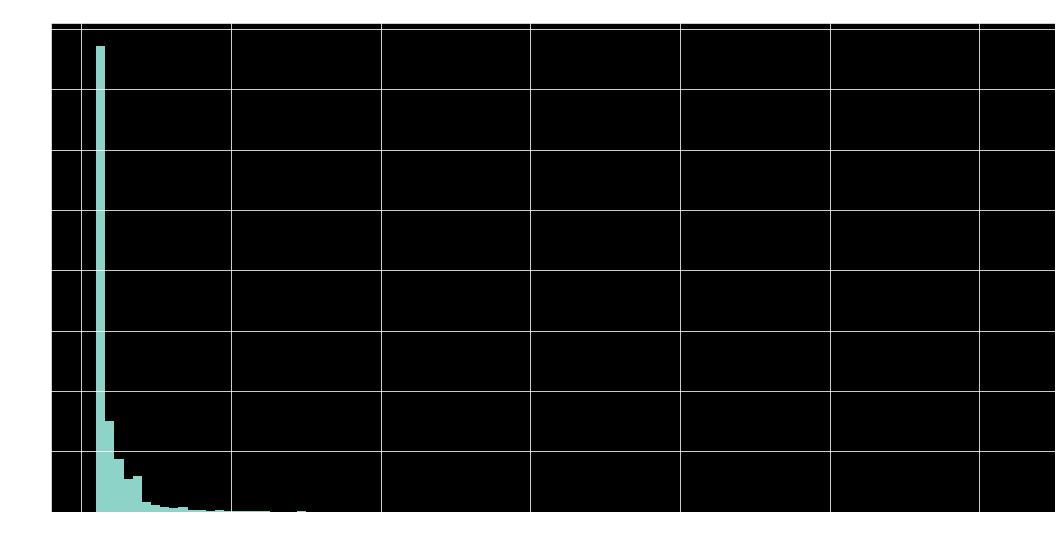

In [88]:
df['user_article']['session_size'].hist(figsize=(18,9), bins=100)
plt.xlabel("Nombre de clics par session")
plt.ylabel("Nombre de sessions")
plt.title("Nombre de clics")
plt.show()

Nous allons zoomer un peu pour voir un peu mieux le nombre de clics par session le plus courrant

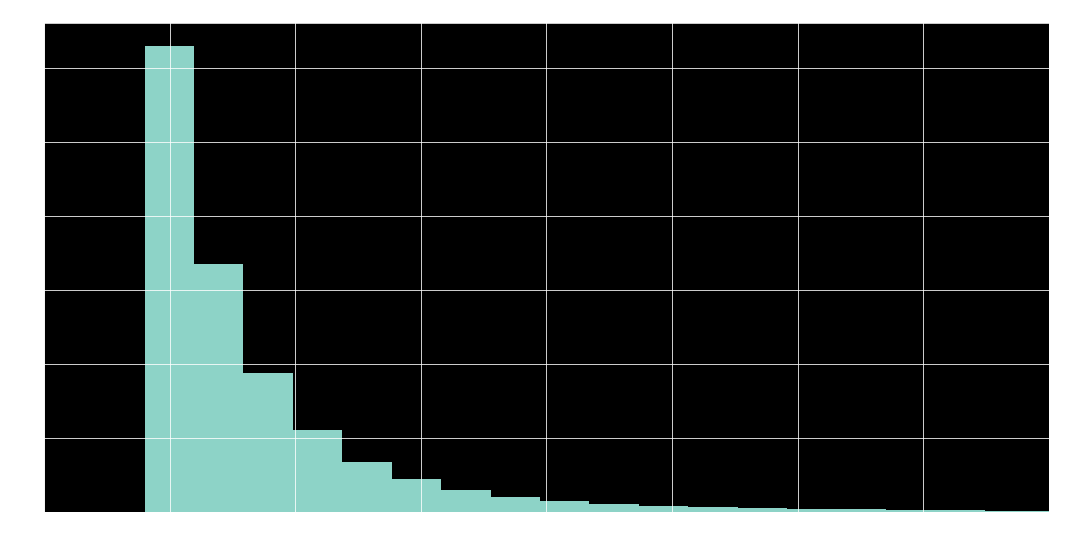

In [87]:
df['user_article']['session_size'].hist(figsize=(18,9), bins=124)
plt.xlim([0,20])
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre de sessions")
plt.title("Nombre de clics par session")
plt.show()

### Répartition du nombre d'articles lus par utilisateur

In [91]:
np.max(df['user_article'].groupby(by="user_id")['click_article_id'].nunique().value_counts())

101518

(0.0, 100.0)

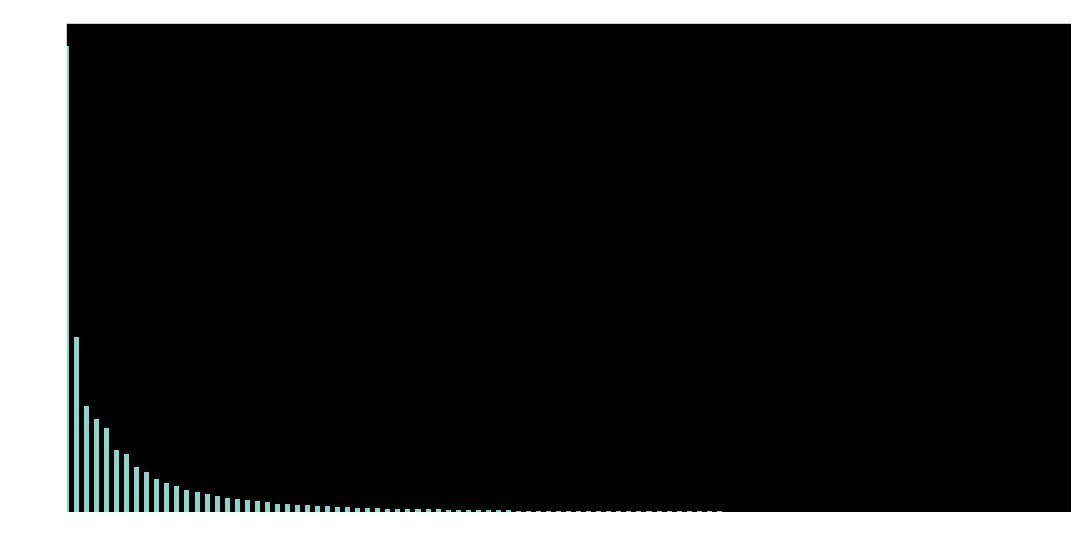

In [96]:
df['user_article'].groupby(by="user_id")['click_article_id'].nunique().value_counts().plot(
    figsize=(18,9),
    kind = 'bar', 
    title="Nombre d'articles lus par utilisateur", 
    xticks=range(0, 100, 10), 
    xlabel = "Nombre d'articles lus", 
    ylabel="Nombre d'utilisateurs"
)
plt.xlim(0,100)

In [363]:
pickle.dump(df, open("df.sav", "wb"))

### Nettoyage des données

Commençons par vérifier s'il existe des doublons

In [101]:
df['user_article'].duplicated().any()

False

Regardons également s'il y a des valeurs manquantes

In [102]:
df['user_article'].isna().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
article_id             0
category_id            0
created_at_ts          0
publisher_id           0
words_count            0
dtype: int64

Il n'y a ni doublon ni valeur nulle.

#### ACP

In [38]:
df_art_emb = pd.DataFrame(
    articles_embeddings,
    columns=["emb_" + str(i) for i in range(articles_embeddings.shape[1])]
)

In [307]:
df_art_emb.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


Nous allons réaliser une ACP afin de réduire le nombre de features de cet embeddings, et donc la taille du fichier

In [39]:
covar_matrix = PCA(
    n_components=articles_embeddings.shape[1]
)
covar_matrix.fit(articles_embeddings)

PCA(n_components=250)

In [316]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    fig = plt.gcf()
    fig.set_size_inches(15,15)
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

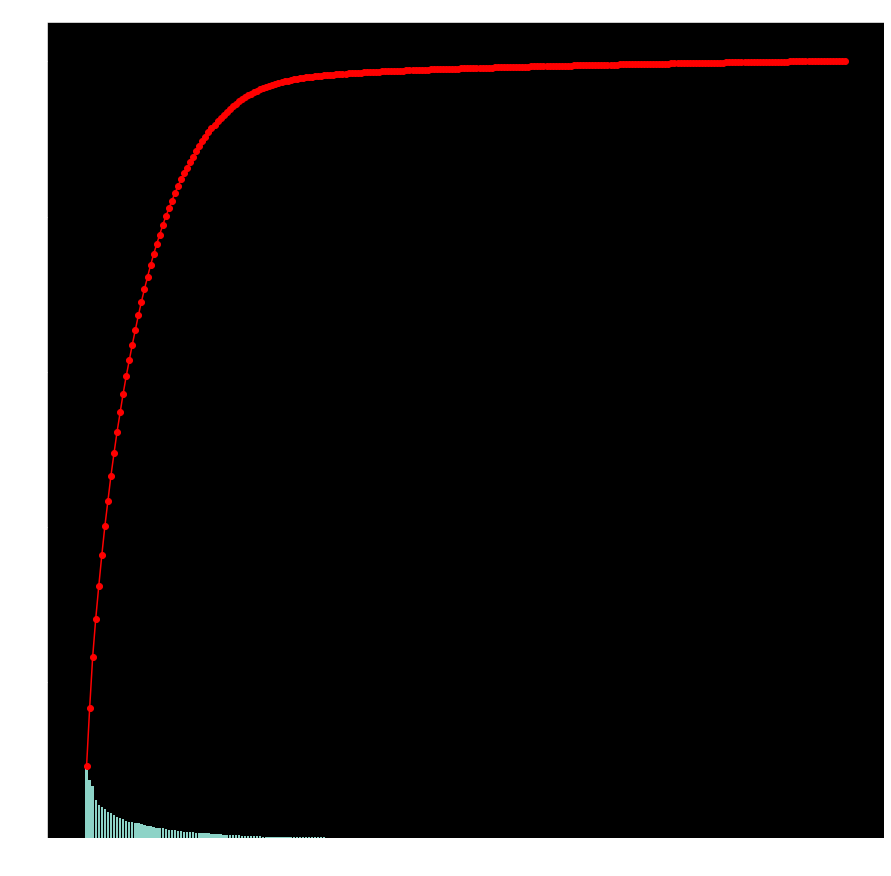

In [317]:
display_scree_plot(covar_matrix)

Text(0, 0.5, 'Variance expliquée et cumulée')

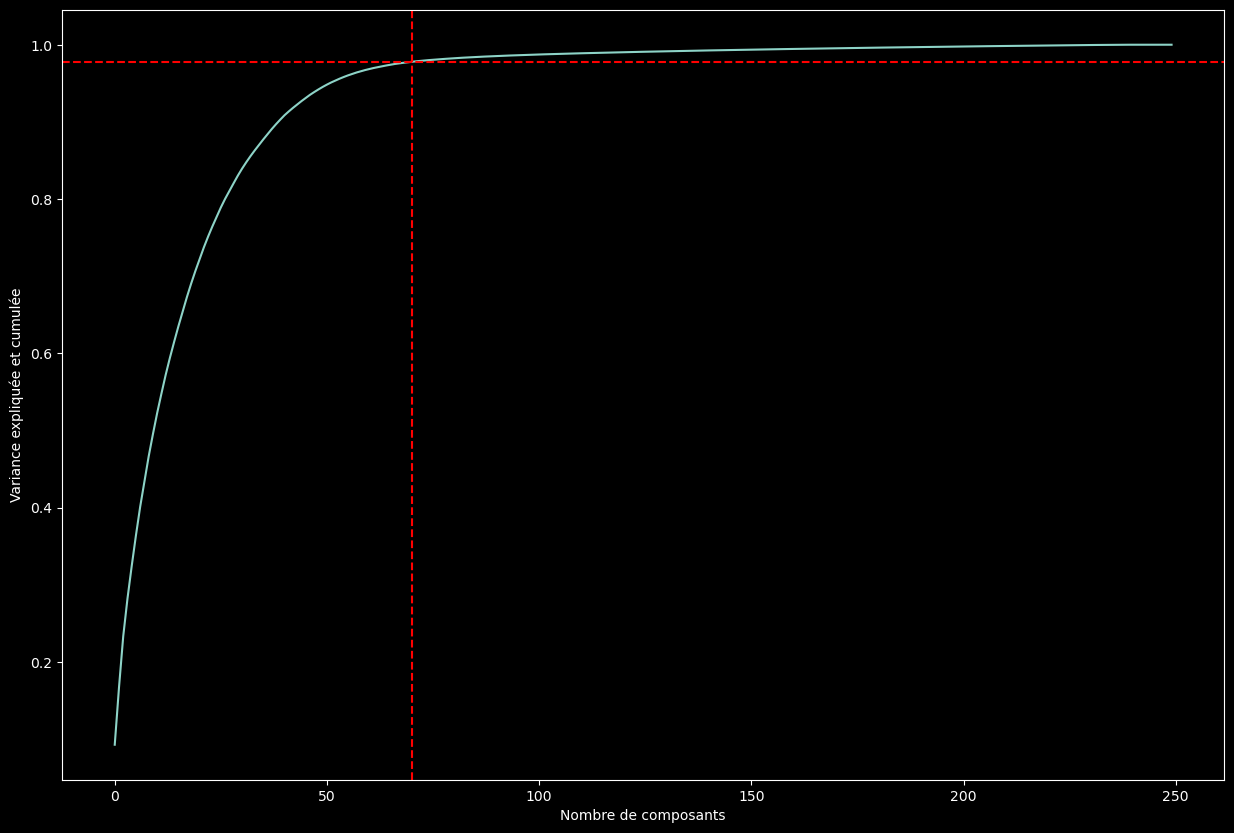

In [56]:
fig = plt.figure(figsize=(15,10)) #

plt.plot(np.cumsum(covar_matrix.explained_variance_ratio_))
plt.axvline(x=70, color="r", linestyle="--")
plt.axhline(y=0.9773075504808983, color="r", linestyle="--")
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée et cumulée')

Nous allons conserver 70 composants

In [54]:
pca = PCA(n_components=70)
pca.fit(df_art_emb)
art_emb_pca = pca.transform(df_art_emb)

In [55]:
variance = sum(pca.explained_variance_ratio_)
print("variance expliquée : ", variance)

variance expliquée :  0.9773075504808983


In [57]:
df_art_emb_pca = pd.DataFrame(
    art_emb_pca,
    columns = ["emb_" + str(i) for i in range(art_emb_pca.shape[1])]
)

In [58]:
df_art_emb_pca.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69
0,-2.176778,-1.316917,-1.029055,0.901900,-1.809533,2.064726,1.221895,0.024460,0.927227,0.669742,...,0.230794,-0.100359,0.049112,0.058206,-0.319569,0.528240,0.113952,-0.417471,-0.002487,0.071560
1,-1.735181,0.489886,3.268564,0.087844,1.473064,0.932691,-1.841634,0.881792,-0.207228,-0.816806,...,-0.103000,0.083815,-0.036991,0.419636,0.298784,-0.111680,-0.146413,0.195302,-0.158367,0.085617
2,-0.912690,-2.089345,1.865867,-1.202533,2.530592,0.521945,-0.224343,-1.479939,-0.191826,-1.356808,...,0.105127,0.102635,0.192903,0.220059,0.142572,-0.136309,0.146346,-0.140555,0.068443,0.269176
3,1.096563,0.212953,4.183521,-0.649570,-0.130879,-1.126562,-1.063989,0.662888,0.348124,-1.463915,...,0.179905,-0.028757,-0.371627,-0.105237,0.365489,0.295829,0.351317,-0.044445,-0.050126,-0.298399
4,0.193779,-0.263952,1.896584,-1.834365,1.270380,1.723270,-0.329014,-0.283813,-0.659787,-1.223723,...,0.448678,-0.348934,0.222146,-0.081992,0.406375,-0.120155,0.379303,0.108424,0.159025,-0.140482


In [59]:
pickle.dump(df_art_emb_pca, open("df_art_env_pca.pkl", "wb"))

# Systèmes de recommandation de contenus

Il existe différentes approches pour les systèmes de recommandation. Ils peuvent être basés sur :
- le contenu (content based RS)
- les métadonnées (content based RS)
- l'historique de chaque utilisateur (collaborative filtering)

### Filtrage collaboratif (Collaborative filtering)

Il s'agit de l’ensemble des techniques qui utilisent le lien utilisateur-produit. Ce lien est représenté par des avis ou des notes, il est utilisé pour construire un système de recommandation personnalisé.  

On peut par exemple retrouver ce genre de systèmes chez Amazon lorsque des articles vous sont recommandés avec la mention "les utilisateurs ayant aimé cet article ont aussi aimé xxx".

Pour faire du filtrage coollaboratif, on peut faire du filtrage basé sur l'utilisateur, ou du filtrage basé sur l'article. Ces notes peuvent être attribuées de façon active (on demande à l'utilisateur de noter l'article), ou passive (par exemple, le nombre d'écoutes d'une musique sur *Spotify*, ou dans notre cas, le nombre de clics sur un article).

On créée une matrice utilisateur-article creuse, c'est-à-dire avec beaucoup de champs vides. Chaque utilisateur dans la base de données peut alors être considéré comme un vecteur incomplet de notes, où la composante **a** est la note de l'utilisateur correspondant à l'article **a**. De la même manière, un article peut être considéré comme un vecteur où chaque composante représente un utilisateur et sa note pour l'article.

#### Préparation des données

In [16]:
df["clicks"].head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [17]:
df["articles_metadata"].head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [39]:
df["user_article"]

,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281
...,...,...,...
2988176,195186,2221,1
2988177,75658,271117,399
2988178,217129,20204,9
2988179,217129,70196,136


In [19]:
tmp = df["user_article"].groupby( # type(tmp) == Series
    [
        "user_id",
        "category_id"
    ]
).size()
df["user_rating"] = tmp.to_frame()
df["user_rating"] = df["user_rating"].reset_index()

df["user_rating"]

,user_id,category_id,0
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


In [20]:
df["user_rating"].rename(
    columns = {0 : "rating"},
    inplace = True
)

In [108]:
df["user_rating"]

,user_id,category_id,rating
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


In [109]:
print("le nombre maximum de clics pour un article est de ", np.max(df["user_rating"]["rating"]))

le nombre maximum de clics pour un article est de  535


Il pourrait être judicieux de normaliser la colonne rating

In [21]:
from sklearn.preprocessing import MinMaxScaler

df["user_rating"]["rating_norm"] = MinMaxScaler(
    feature_range=(0,1)
).fit_transform(
    np.array(df["user_rating"]["rating"]).reshape(-1,1)
)

In [111]:
pickle.dump(df, open("df.sav", "wb"))

In [112]:
df["user_rating"]

,user_id,category_id,rating,rating_norm
0,0,136,1,0.000000
1,0,186,2,0.001873
2,0,209,1,0.000000
3,0,281,2,0.001873
4,0,375,1,0.000000
...,...,...,...,...
1882297,322894,297,1,0.000000
1882298,322895,133,1,0.000000
1882299,322895,418,1,0.000000
1882300,322896,26,1,0.000000


In [53]:
X_cf = df["user_rating"][
    [
        "user_id",
        "category_id",
        "rating_norm"
    ]
]

In [16]:
X_cf = X_cf[X_cf["rating_norm"]!=0.]

Nous allons maintenant utiliser un *reader* de la librairie *Surprise*. La classe *Reader* est utilisée pour parser un dataframe contenant des notes

In [18]:
len(X_cf["rating_norm"][X_cf["rating_norm"]!=0.])

503616

In [17]:
len(X_cf) - len(X_cf["rating_norm"][X_cf["rating_norm"]==0.])

503616

In [19]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(
    X_cf[
        [
            "user_id",
            "category_id",
            "rating_norm"
        ]
    ],
    reader
)

In [196]:
print("Nombre d'interactions : ", len(X_cf))

Nombre d'interactions :  1882302


#### Préparation des données pour l'entraînement

Séparons maintenant notre jeu de données en jeu d'entraînement et jeu de test

In [20]:
train, test = train_test_split(
    data,
    test_size=0.2
)

In [21]:
pickle.dump(X_cf, open("X_cf.pkl", "wb"))
pickle.dump(data, open("data.pkl", "wb"))
pickle.dump(train, open("train.pkl", "wb"))
pickle.dump(test, open("test.pkl", "wb"))

In [2]:
X_cf = pickle.load((open("X_cf.pkl", "rb")))
data = pickle.load((open("data.pkl", "rb")))
train = pickle.load((open("train.pkl", "rb")))
test = pickle.load((open("test.pkl", "rb")))

In [50]:
type(train)

surprise.trainset.Trainset

In [51]:
type(test)

list

In [117]:
print("le jeu de test comprend {} lignes".format(len(test)))
print("le jeu d'entraînement' comprend {} lignes".format(len(X_cf)-len(test)))

le jeu de test comprend 376461 lignes
le jeu d'entraînement' comprend 1505841 lignes


### Benchmark des algorithmes

Et si nous testions et comparions plusieurs algorithmes ?

Voici la liste des algorithmes que nous allons tester :

- **NormalPredictor** : L'algorithme NormalPredictor prédit une note aléatoire basée sur la distribution de l'ensemble d'apprentissage, qui est supposé être normal. C'est l'un des algorithmes les plus basiques qui ne fonctionne bien évidemment pas beaucoup

- **BaselineOnly** : Cet algorithme prédit une estimation de base pour un utilisateur et un élément donnés

- **SVD** : L'algorithme SVD est équivalent à la factorisation matricielle probabiliste [https://proceedings.neurips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf](https://proceedings.neurips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf)

- **SVDpp** : L'algorithme SVDpp est une extension de SVD qui prend en compte les notations implicites.

- **NMF** : NMF est un algorithme de filtrage collaboratif basé sur la factorisation matricielle non négative. C'est très similaire à SVD.

- **Slope One** : Slope One est une implémentation simple de l'algorithme SlopeOne [https://arxiv.org/abs/cs/0702144](https://arxiv.org/abs/cs/0702144)

- **Co-clustering** : un algorithme de filtrage collaboratif basé sur le co-clustering (https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)[https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf]

#### Métriques

Les métriques que nous utiliserons sont :
- la racine de l'erreur quadratique moyenne (**RMSE**)
- l'erreur absolur moyenne (**MAE**)

##### Définitions

La **MSE**, ou erreur quadratique moyenne, est la moyenne des carrés des erreurs, définie par la formule : 
${{MSE = \frac{1}{n} \sum_{i=1}^n e_i^2 = \frac{1}{n} \sum_{i=1}^n (y_i – \hat{y}_i)^2 }}$

La **RMSE**, ou racine de l’erreur quadratique moyenne, est – comme son nom l’indique – la racine carrée de la **MSE**. Mathématiquement, elle est définie par : 

${{RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i – \hat{y}_i)^2}}}$ 

Contrairement à la **MSE**, la **RMSE** s’exprime dans la même unité que la variable à prédire et est par conséquent plus facile à interpréter. Ces métriques quantifient les erreurs réalisées par le modèle. Plus elles sont élevées, moins le modèle est performant.

La **MAE**, ou erreur absolue moyenne, est la moyenne des valeurs absolues des erreurs, définie par la formule :

${{MAE = \frac{1}{n} \sum_{i=1}^n |e_i| = \frac{1}{n} \sum_{i=1}^n |y_i – \hat{y}_i|}}$

La **MAE** est dans la même unité que la variable à prédire. Par conséquent, elle est facile à interpréter.

Cette métrique quantifie l’erreur réalisée par le modèle. Plus elle est élevée, moins le modèle est performant.

In [198]:
benchmark = []

algorithms = [
    SVD(), 
    SVDpp(), 
    SlopeOne(), 
    NMF(), 
    NormalPredictor(), 
#     KNNBaseline(), # demande trop de mémoire
#     KNNBasic(), # idem
#     KNNWithMeans(), 
#     KNNWithZScore(), 
    BaselineOnly(), 
    CoClustering()
]

for algorithm in algorithms:
    print("Début: " ,str(algorithm))
    # Effectue la validation croisée
    results = cross_validate(
        algorithm, 
        data, 
        measures=["RMSE", "MAE"], 
        cv=3, 
        verbose=False
    )

    
    # Associe les résultats et les noms des algorithmes
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(
        pd.Series(
            [str(algorithm).split(' ')[0].split('.')[-1]], 
            index=['Algorithm']
        )
    )
    benchmark.append(tmp)
    print("Fin: " ,str(algorithm), "\n\n")

print ('\n\tTERMINÉ\n')

Début:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002A741918C70>


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


Fin:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002A741918C70> 


Début:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000002A741919810>


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


Fin:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000002A741919810> 


Début:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000002A7419196C0>


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


Fin:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000002A7419196C0> 


Début:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000002A7419184C0>


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


Fin:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000002A7419184C0> 


Début:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000002A74191B340>


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


Fin:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000002A74191B340> 


Début:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x000002A74191ABF0>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


Fin:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x000002A74191ABF0> 


Début:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x000002A741919A20>
Fin:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x000002A741919A20> 



	TERMINÉ



C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_780\2037993766.py:46: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(


In [199]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [200]:
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.003435,0.001391,3.512999,1.803000
SlopeOne,0.003673,0.001573,2.584334,4.942999
NMF,0.003752,0.001119,28.937999,4.921168
CoClustering,0.003765,0.001128,45.746334,2.191500
SVDpp,0.003804,0.001489,16.660834,13.544000
NormalPredictor,0.004463,0.002452,1.590500,1.788333
SVD,0.005112,0.001670,12.457150,5.390833


In [201]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_mae')

In [202]:
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
NMF,0.003752,0.001119,28.937999,4.921168
CoClustering,0.003765,0.001128,45.746334,2.191500
BaselineOnly,0.003435,0.001391,3.512999,1.803000
SVDpp,0.003804,0.001489,16.660834,13.544000
SlopeOne,0.003673,0.001573,2.584334,4.942999
SVD,0.005112,0.001670,12.457150,5.390833
NormalPredictor,0.004463,0.002452,1.590500,1.788333


### Fine Tuning

#### NMF

In [210]:
param_grid = {
    "n_factors": [5,10,15],
    "n_epochs": [25, 50],
#     "biased": [True, False],
    "reg_pu": [0.04,0.06,0.08],
    "reg_qi": [0.04,0.06,0.08],
}
gs = GridSearchCV(
    NMF, 
    param_grid, 
    measures=["rmse", "mae"], 
    refit=True, 
    cv=5
)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["mae"])

BEST RMSE: 	 0.00375291586030639
BEST MAE: 	 0.0011030216710017368
BEST params: 	 {'n_factors': 5, 'n_epochs': 25, 'reg_pu': 0.04, 'reg_qi': 0.04}


In [217]:
pickle.dump(training_parameters, open("NMF_training_parameters", "wb"))

#### Entraînement avec les meilleurs paramètres

In [3]:
# algo = gs.best_estimator["mae"]
algo = NMF(
    n_factors=5,
    n_epochs=25,
    reg_pu=0.04,
    reg_qi=0.04
)
algo.fit(train)

In [23]:
predictions = algo.test(test)
print("Nombre de prédictions : ", len(predictions))

Nombre de prédictions :  100724


#### Évaluation

In [213]:
accuracy.mae(predictions)

MAE:  0.0011


0.0010987106592538131

In [214]:
accuracy.rmse(predictions)

RMSE: 0.0036


0.003645206926031605

#### Sauvegarde du modèle

In [4]:
# certains modèles ne peuvent être sauvegardés avec Surprise v1.1.2
# Dans mon cas, la meilleure solution était de downgrade vers v1.1.1
# Un ticket a été ouvert sur github
model_filename = "./_NMF_model"
print (">> Starting dump")
file_name = os.path.expanduser(model_filename)
# dump.dump(file_name, algo=algo, predictions=predictions)
dump.dump(file_name, algo=algo)
print (">> Dump done")
print(model_filename)

>> Starting dump
>> Dump done
./_NMF_model


In [52]:
# Sauvegardons également les fichiers qui seront nécessaires à notre application
df_clicks_azure = df_tmp["clicks"][["user_id", "click_article_id"]]
pickle.dump(df_clicks_azure, open("df_clicks_azure.pkl", "wb"))

#### Création du système de recommandation

Nous allons d'abord créer une fonction qui retournera les top-N recommandations pour chaque utilisateur depuis un ensemble de prédictions. Cette fonction va d'abord mapper les prédicitons pour chaque utilisateur, puis va trier les prédictions pour chaque utilisateur pour récupérer les K prédictions avec le score le plus élevé

In [5]:
def get_recommandation_cf(user_id, articles, clicks, algo, n=10):
    idx=list(articles.index)
    articles_read = clicks[
        clicks["user_id"] == user_id
    ]["click_article_id"].tolist()
    for item in articles_read:
        if item in idx:
            idx.remove(item)
    res = {}
    for i in idx:
        pred = algo.predict(user_id, i)
        res[pred.iid]=pred.est
    return nlargest(n, res, key=res.get)

In [361]:
reco_cf = get_recommandation_cf(42, df_art_emb, df["clicks"], algo)
reco_cf

[140, 216, 232, 268, 293, 295, 303, 304, 311, 316]

In [362]:
reco_cf_pca = get_recommandation_cf(42, df_art_emb_pca, df["clicks"], algo)
reco_cf_pca

[140, 216, 232, 268, 293, 295, 303, 304, 311, 316]

## Content-based : En utilisant l'embedding des articles

Nous allons ici utiliser le calcul du cosinus entre les articles lus par l'utilisateur et les autres articles projetés dans un espace vectoriel via la matrice d'embeddings

In [352]:
df["clicks"].head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [335]:
def get_recommandation_cb(user_id, articles, clicks, n=10):
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()
    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"
    articles_read_embedding = articles.loc[articles_read]
    articles = articles.drop(articles_read)
    matrix = cosine_similarity(articles_read_embedding, articles)
    recommandations = []
    for i in range(n):
        coord_x = floor(np.argmax(matrix)/matrix.shape[1])
        coord_y = np.argmax(matrix)%matrix.shape[1]
        recommandations.append(int(articles.index[coord_y]))
        matrix[coord_x][coord_y] = 0
    return recommandations

Nous allons comparer les résultats entre l'utilisation du fichier d'embeddings d'origine et l'embeddings réduit par l'ACP

In [350]:
reco_emb = get_recommandation_cb(1, df_art_emb, df["clicks"], 5)
reco_emb_pca = get_recommandation_cb(1, df_art_emb_pca, df["clicks"], 5)
print(reco_emb)
print(reco_emb_pca)
print(sorted(reco_emb))
print(sorted(reco_emb_pca))

[228299, 235079, 233829, 228944, 345924]
[228299, 345924, 235079, 233829, 228944]
[228299, 228944, 233829, 235079, 345924]
[228299, 228944, 233829, 235079, 345924]


On peut constater que les résultats sont similaires